In [1]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

memory = MemorySaver()

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

class BasicState(TypedDict): 
    messages: Annotated[List, add_messages]

def model(state: BasicState): 
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BasicState): 
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and 
    len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return END


graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.set_entry_point("model")
graph.add_conditional_edges("model", tools_router)

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

C:\Users\KAIZEN\AppData\Local\Temp\ipykernel_12060\312706044.py:11: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=2)


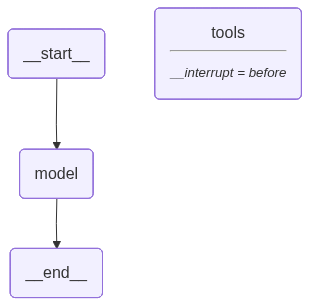

In [2]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [5]:

config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Chennai?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Chennai?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (79pspyvss)
 Call ID: 79pspyvss
  Args:
    query: Current weather in Chennai


In [6]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [7]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (79pspyvss)
 Call ID: 79pspyvss
  Args:
    query: Current weather in Chennai
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Chennai weather in October 2025 - Weather25.com", "url": "https://www.weather25.com/asia/india/tamil-nadu/chennai?page=month&month=October", "content": "| 26 Partly cloudy 33° /26° | 27 Sunny 32° /27° | 28 Sunny 32° /25° | 29 Sunny 31° /26° | 30 Patchy rain possible 31° /26° | 31 Sunny 30° /26° |  | [...] weather25.com\nSearch\nweather in India\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in India\n\n# Chennai weather in October 2025\n\nPatchy rain possible\nLight rain shower\nLight rain shower\nLight rain shower\nPatchy rain possible\nPatchy rain possible\nPatchy rain possible\nPartly cloudy\nClear\nClear\nClear\nPatchy rain possible\n